In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import plotly.express as px
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
price_df = pd.read_csv("price_data.csv",
                       parse_dates=["GMT Time"],
                       na_values=['No Data Available']
                       )
price_df.columns = ["Time", "DA Price", "Intraday Price"]
# price_df.set_index("Time", inplace=True)
# price_df.rename_axis("Series", axis="columns", inplace=True)

generation_df = pd.read_csv("generation_data.csv",
                            parse_dates=["GMT Time"],
                            na_values=["No Data Available"])
generation_df.columns = ["Time",
                         "Biomass",
                         "Gas",
                         "Hard Coal",
                         "Oil",
                         "Hydro Pumped Storage",
                         "Hydro Run-of-River",
                         "Nuclear",
                         "Solar",
                         "Wind Onshore",
                         "Wind Offshore"]
# generation_df.set_index("Time", inplace=True)
# generation_df.rename_axis("Series", axis="columns", inplace=True)

demand_load_df = pd.read_csv("demand_load_data.csv",
                             parse_dates=["GMT Time"],
                             na_values=["No Data Available"])
demand_load_df.columns = ["Time", "Loss of Load Prob", "Actual Total Load", "Demand Outturn"]
# demand_load_df.set_index("Time", inplace=True)
# demand_load_df.rename_axis("Series", axis="columns", inplace=True)

balancing_df = pd.read_csv("balancing_data.csv",
                           parse_dates=["GMT Time"],
                           na_values=['No Data Available']
                           )
balancing_df.columns = ["Time",
                        "System Price",
                        "NIV Outturn",
                        "BM Bid Acceptances",
                        "BM Offer Acceptances",
                        "BSAD Volume Turn Up",
                        "BSAD Volume Turn Down",
                        "BSAD Volume Total",
                        "Intraday Volume"]
# balancing_df.set_index("Time", inplace=True)
# balancing_df.rename_axis("Series", axis="columns", inplace=True)

### Price data

After taking a look at the data, we moved on to do exploratory analysis. The first thing we did was decide what to do with the missing values we found above. The first measure we took was to handle them with forward fill, making them valid while not overwriting the data (mainecita's notes, can be changed)

In [ ]:
print("Missing values:\n", price_df['DA Price'].isnull().sum())
price_df['DA Price'] = price_df['DA Price'].fillna(method='ffill')  # Forward fill method for missing values



Missing values:
 64


<ipython-input-10-ac8f3273b644>:2: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



The next thing we did was look for stationarity. For this we did an Augmented Dickey-Fuller (ADF) test.

For this, we decided upon the following Hypothesis to test:

Null Hypothesis (𝐻0): The time series is non-stationary.
Alternative Hypothesis (𝐻1): The time series is stationary.

In [ ]:
adfuller(price_df['DA Price'])

(-8.107524272214649,
 1.2511923718248523e-12,
 71,
 118248,
 {'1%': -3.430405302770123,
  '5%': -2.861564442999535,
  '10%': -2.5667830101460924},
 1012468.3553004458)

The results show that the ADF statistic is much smaller than all critical values, so we reject the null hypothesis. At the same time, they show a small p-value, meaning that we reject the null hypothesis. With these results we thus assume stationarity. This means we do not need to apply transformations to the data before modeling it.

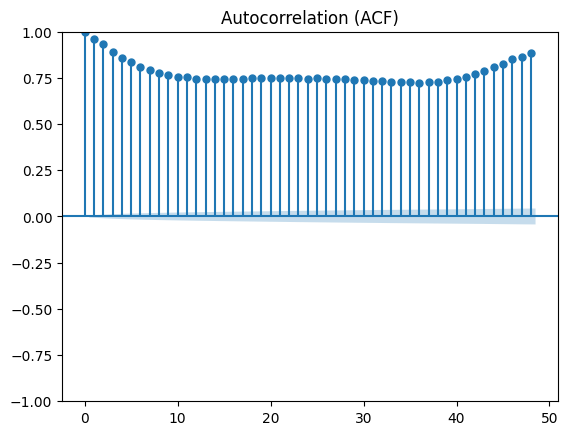

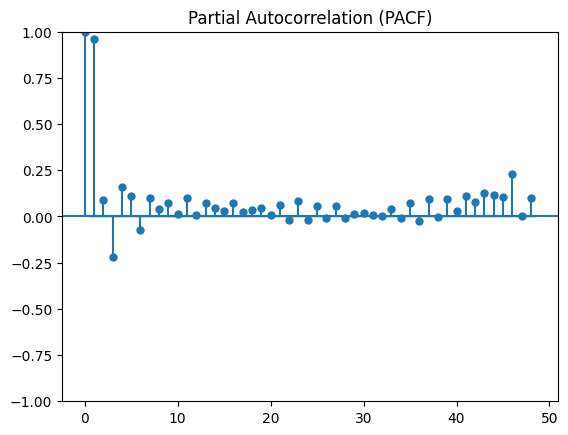

In [ ]:
#ACF
plot_acf(price_df['DA Price'], lags=48) #Lags are the cycles, set to 48 since the data is set to 48-intervals
plt.title("Autocorrelation (ACF)")
plt.show()

#PACF
plot_pacf(price_df['DA Price'], lags=48)
plt.title("Partial Autocorrelation (PACF)")
plt.show()

The ACF plot shows a slow decay over time, with significant correlations for many lags. This can indicate non-stationarity, as the autocorrelations do not drop off quickly. This can also suggest the presence of trends or seasonality in the data. Differencing can remove this persistence in correlations.

The PACF plot shows a sharp drop-off after lag 1, with no significant spikes beyond that. This can tell us that a lag of 1 might be sufficient for the autoregressive (AR) part of the model.


In [ ]:
#Deciding the split of the training/Test datasets
len(price_df['DA Price'])

split_index = (len(price_df['DA Price']) * 0.8)

split_index

94656.0

In [ ]:
# Training data: 80% of the data
train_data = price_df['DA Price'][:94656]
 #This is what Michelle told us to do in the call
# I selected a smaller subset of data to see if it runs - Mainecita


# Test data: Remaining 20% of the data
test_data = price_df['DA Price'][94656:]

In [ ]:
# Fit ARIMA Model
# Parameters determined from PACF and ACF (p=1, d=1, q=1)
# I get a warning when running it, Even though the data passed the ADF test for stationarity,
# small numerical issues or borderline stationarity can trigger this warning.
p = 1
d = 1
q = 1
arima_model = ARIMA(train_data, order=(p, d, q))
arima_fit = arima_model.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
# Forecast using ARIMA
arima_forecast = arima_fit.forecast(steps=48)  # Forecast 48 half-hour intervals
arima_forecast

,predicted_mean
94656,74.196051
94657,73.429563
94658,73.965582
94659,73.590734
94660,73.852872
94661,73.669554
94662,73.797751
94663,73.708101
94664,73.770795
94665,73.726952


In [ ]:
# Fit SARIMA Model
# Seasonal parameters (P=1, D=0, Q=0, m=48) based on daily seasonality assumption
P, D, Q, m = 1, 0, 0, 48
sarima_model = SARIMAX(train_data, order=(p, d, q), seasonal_order=(P, D, Q, m))


train_data = train_data[-10000:]

In [ ]:
sarima_fit = sarima_model.fit(disp=False)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



In [ ]:
# Forecast using SARIMA
sarima_forecast = sarima_fit.forecast(steps=48)

In [ ]:
# Evaluate Models
def evaluate_forecast(actual, forecast, model_name):
    mae = mean_absolute_error(actual, forecast)
    mse = mean_squared_error(actual, forecast)
    rmse = np.sqrt(mse)
    print(f"{model_name} Evaluation:")
    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print("-" * 30)

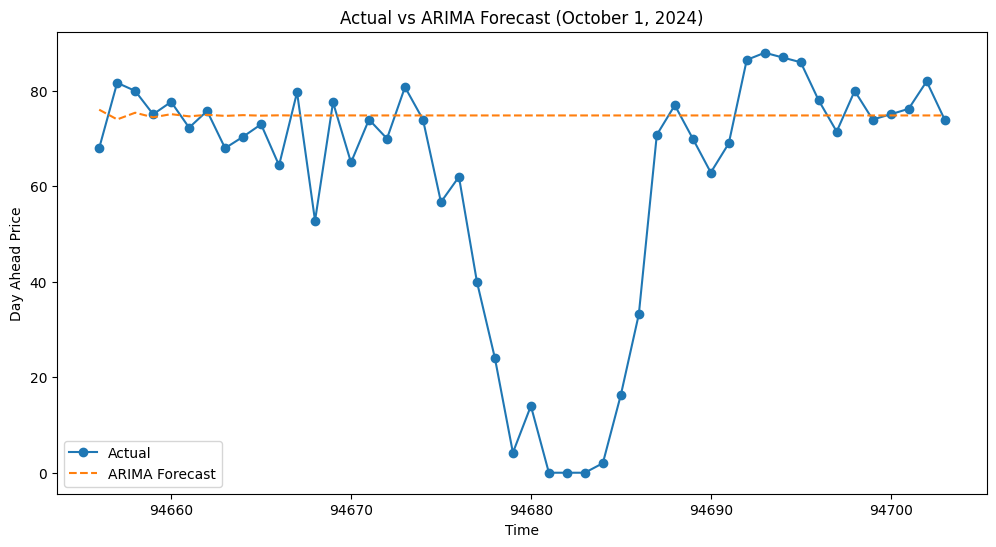

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_48.index, test_data_48.values, label="Actual", marker='o')
plt.plot(test_data_48.index, arima_forecast, label="ARIMA Forecast", linestyle='--')
plt.title("Actual vs ARIMA Forecast (October 1, 2024)")
plt.xlabel("Time")
plt.ylabel("Day Ahead Price")
plt.legend()
plt.show()

((Here is where I got lost))

In [ ]:
# Evaluate ARIMA
evaluate_forecast(test_data.values, arima_forecast, "ARIMA")

# Evaluate SARIMA
evaluate_forecast(test_data.values, sarima_forecast, "SARIMA")

ValueError: Found input variables with inconsistent numbers of samples: [23664, 48]

In [ ]:
balancing_df['NIV Outturn'] = balancing_df['NIV Outturn'].fillna(method='ffill')
niv_arima_model = ARIMA(balancing_df['NIV Outturn'], order=(1, 1, 1))
niv_arima_fit = niv_arima_model.fit()
niv_forecast = niv_arima_fit.forecast(steps=48)

NameError: name 'balancing_df' is not defined